In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#Linear Algebra Calculations, Data Manipulation and Visualization Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (15,10)

#utilities
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

#Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

## Reading the Data

In [2]:
df =  pd.read_csv('../input/financial-dataset-for-fraud-detection-in-a-comapny/Fraud.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Changing datatypes for performance speed

In [4]:
df[['amount', 'oldbalanceOrg','newbalanceOrig', 'oldbalanceDest','newbalanceDest']] = df.select_dtypes('float64').astype('float16')

In [5]:
df[['step', 'isFraud', 'isFlaggedFraud']] = df.select_dtypes('int64').astype('int64')

In [6]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace =True)

In [7]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9840.0,inf,inf,0.0,0.0,0,0
1,1,PAYMENT,1864.0,21248.0,19392.0,0.0,0.0,0,0
2,1,TRANSFER,181.0,181.0,0.0,0.0,0.0,1,0
3,1,CASH_OUT,181.0,181.0,0.0,21184.0,0.0,1,0
4,1,PAYMENT,11672.0,41568.0,29888.0,0.0,0.0,0,0


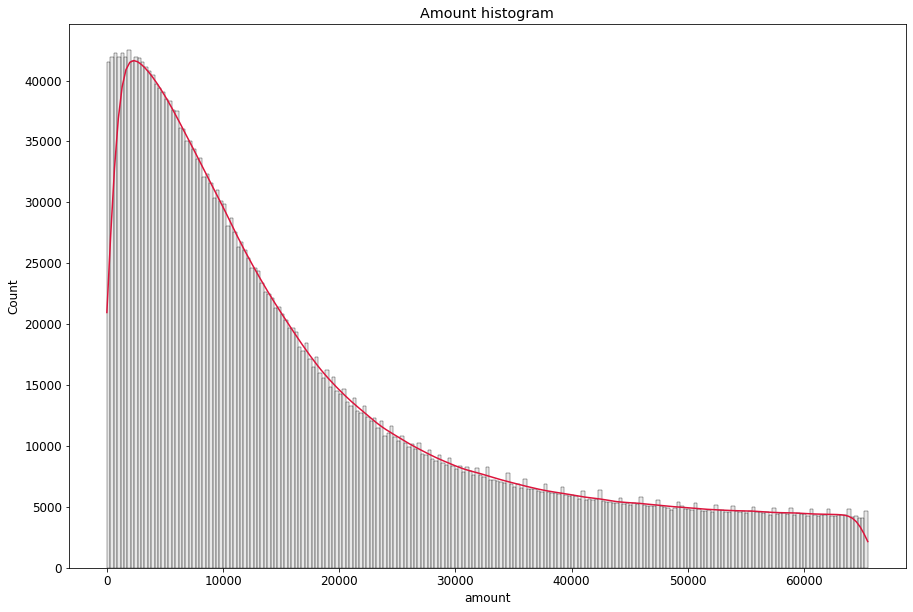

In [8]:
ax= sns.histplot(df['amount'], kde=True, color='lightgray')
ax.lines[0].set_color('crimson')
plt.title('Amount histogram')
plt.show()

In [9]:
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no null values in the dataset

In [10]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Above Cell shows we have an imbalanced dataset

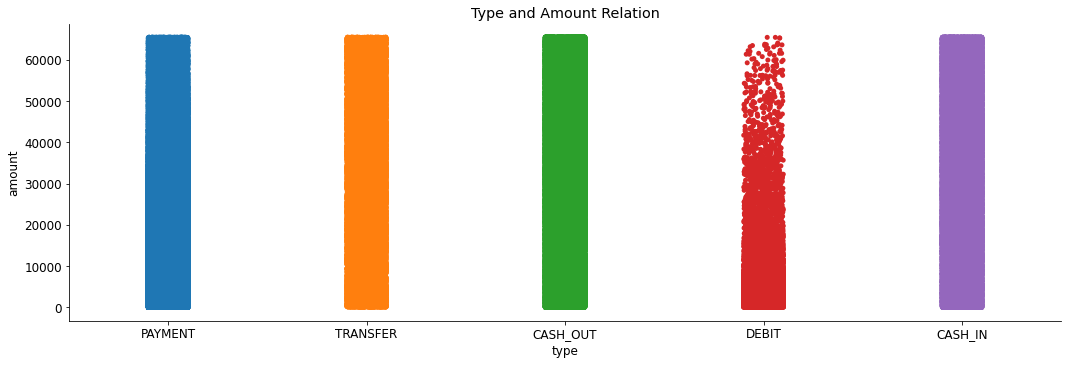

In [11]:
sns.catplot(data=df,x= 'type',y='amount', hue='type', aspect=3)
plt.title('Type and Amount Relation')
plt.show()

**OneHotEncoding**

In [12]:
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
categorical_col = df.select_dtypes('object').columns.tolist()
encoder.fit(df[categorical_col])
encoder.categories_

[array(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
       dtype=object)]

In [13]:
encoded_col = list(encoder.get_feature_names_out(categorical_col))
print(encoded_col)

['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [14]:
df[encoded_col] = encoder.transform(df[categorical_col])
df.drop('type', axis=1, inplace=True)

In [15]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9840.0,inf,inf,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
1,1,1864.0,21248.0,19392.0,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
2,1,181.0,181.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,1.0
3,1,181.0,181.0,0.0,21184.0,0.0,1,0,0.0,1.0,0.0,0.0,0.0
4,1,11672.0,41568.0,29888.0,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0


In [16]:
#Dropping those rows by the index where value is `inf` and then resetting the index
df1 = df.drop(index=df.index[np.isinf(df).any(1)], axis=0).reset_index().drop('index', axis=1)

In [17]:
#Dataframe where `isFraud` = True
frauddf = df1[df1['isFraud']==1]

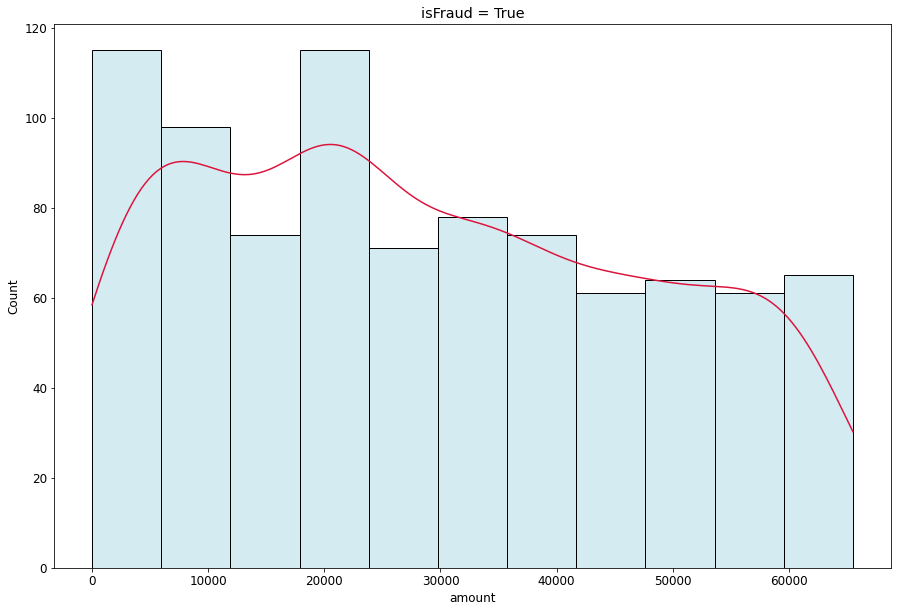

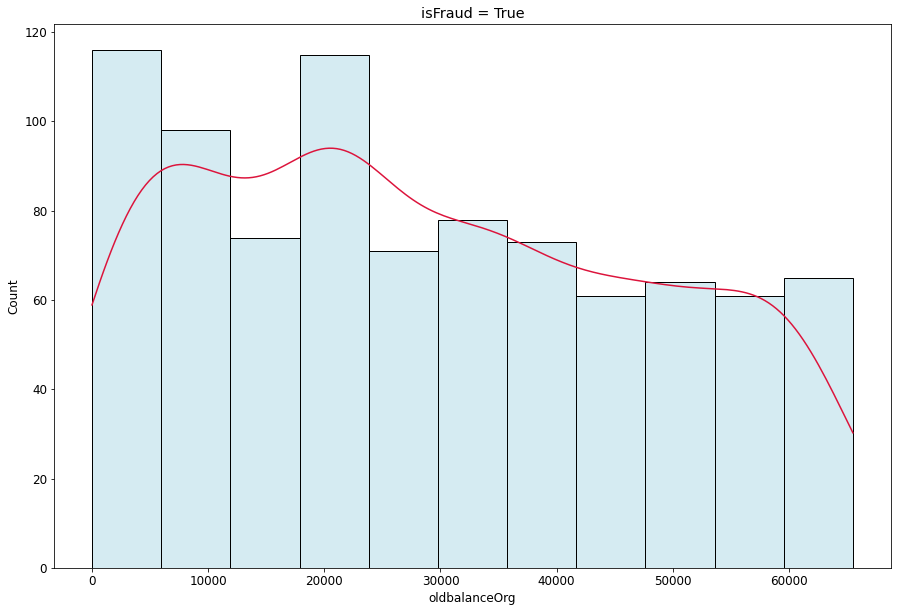

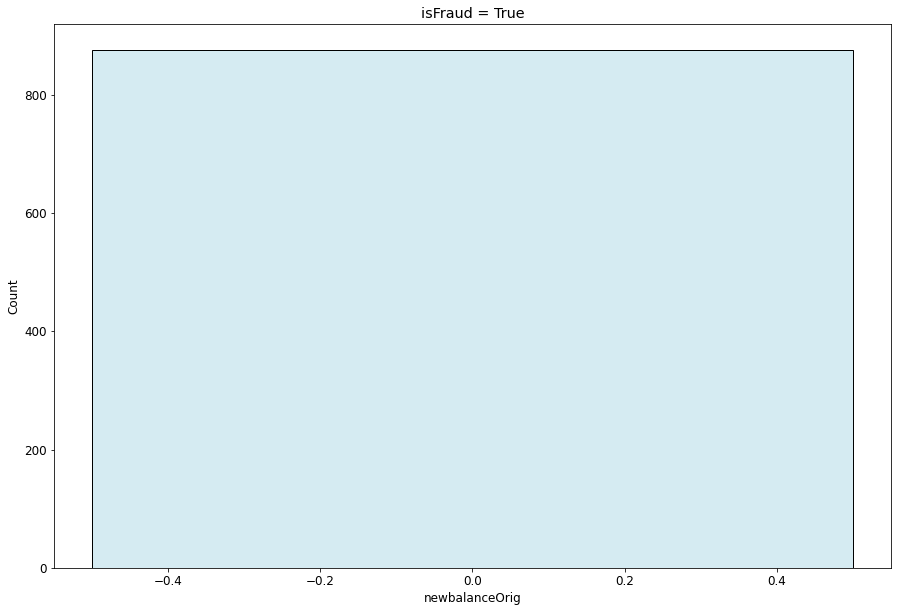

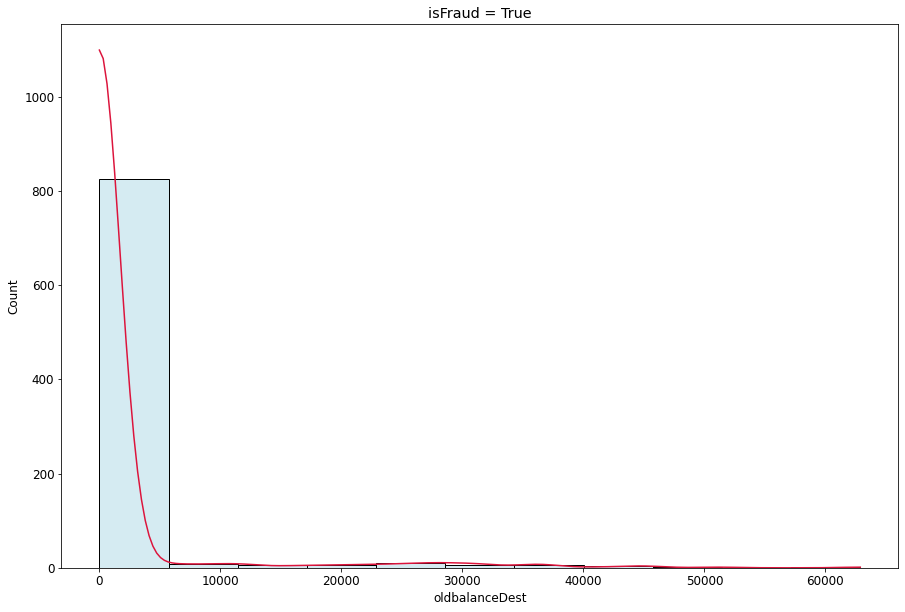

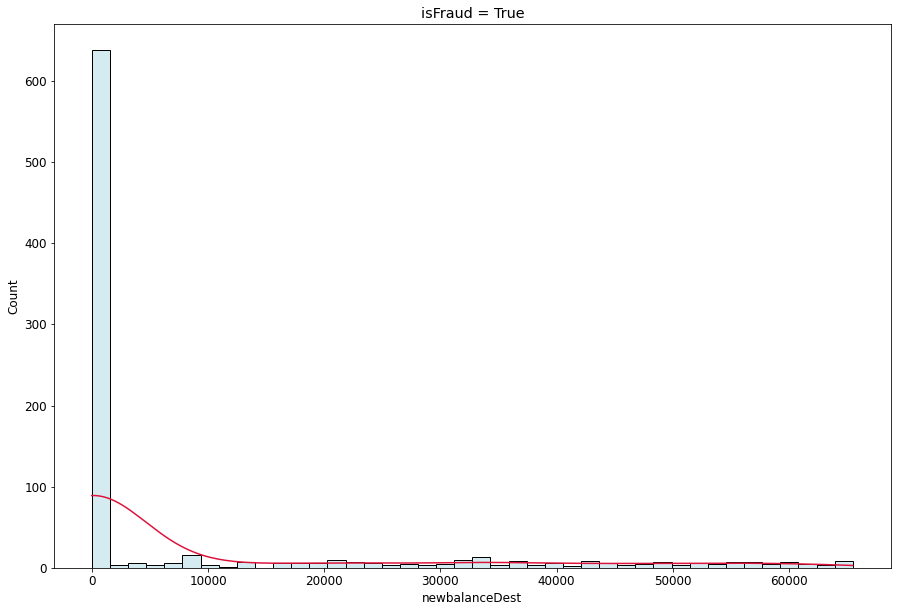

In [18]:
for i in frauddf.columns[1:6]:
    ax = sns.histplot(frauddf[i], kde=True, color='lightblue')
    try:
        ax.lines[0].set_color('crimson')
    except: 
        pass
    plt.title('isFraud = True')
    plt.xlabel(i)
    plt.show()

From the charts above, we could see that the frauds are majorly happening where the amount is on the lower end.

In [19]:
inputcols = [i for i in df1.columns if i!='isFraud']
df1[inputcols]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,1864.0,21248.0,19392.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0
1,1,181.0,181.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0
2,1,181.0,181.0,0.0,21184.0,0.0,0,0.0,1.0,0.0,0.0,0.0
3,1,11672.0,41568.0,29888.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0
4,1,7816.0,53856.0,46048.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1728967,741,62304.0,62304.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0
1728968,741,48448.0,48448.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0
1728969,742,54656.0,54656.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0
1728970,742,54656.0,54656.0,0.0,0.0,54656.0,0,0.0,1.0,0.0,0.0,0.0


In [20]:
y = df1['isFraud']
X = df1[inputcols]

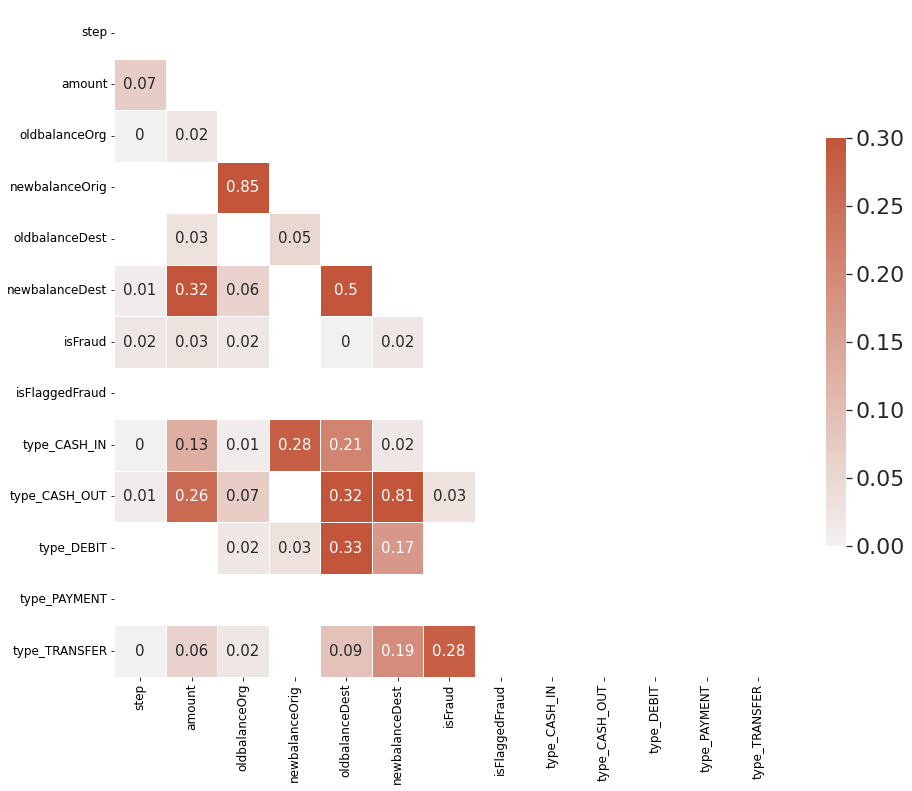

In [21]:
corr = df1.corr()
corr = np.around(corr[corr > 0.0],2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=2)
cmap = sns.diverging_palette(220,20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask = mask, vmax=.3, center=0, annot=True, square=True, 
            linewidths=.9, cbar_kws={'shrink': .5},annot_kws={"size": 15})
plt.show()

In [22]:
df1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,1864.0,21248.0,19392.0,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
1,1,181.0,181.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,1.0
2,1,181.0,181.0,0.0,21184.0,0.0,1,0,0.0,1.0,0.0,0.0,0.0
3,1,11672.0,41568.0,29888.0,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
4,1,7816.0,53856.0,46048.0,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0


## Seperating Independent and Dependent Variable

In [23]:
X = df1[['amount', 'oldbalanceOrg', 'type_TRANSFER', 'type_CASH_OUT']].values
y = df1['isFraud'].values

## Scaling and Under Sampling

In [24]:
#UnderSampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
#Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_res)

In [25]:
X_scaled[:,0]

array([0.07999511, 0.03538715, 0.38177821, ..., 0.83439179, 0.83439179,
       0.96824621])

In [26]:
weight_for_0 = (len(y_res[y_res==0]))/(y_res.shape[0])
weight_for_1 = (len(y_res[y_res==1]))/(y_res.shape[0])
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'The weights of the classes after resampling is {class_weight}')

The weights of the classes after resampling is {0: 0.5, 1: 0.5}


We see that the classes are now balanced as the occurence of both the classes in our target `y_res` values is 50% each

## Splitting and Training 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.33, random_state=42)

In [28]:
names = ['Logistic Regression', "XGB Classifier", "Random Forest"]
classifiers = [
    LogisticRegression(solver='liblinear', penalty='l2', n_jobs=-1, random_state=0),
    XGBClassifier(objective='binary:hinge'),
    RandomForestClassifier(max_depth=5, n_estimators=100)]

modelscores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)           #Training the model on Training Set
    score = clf.score(X_test, y_test)   #Scoring On Validation Set
    modelscores.append(score)
    
scores_df = pd.DataFrame()
scores_df['name'] = names
scores_df['score'] = np.around(modelscores,4)
scores_df.sort_values('score', ascending= False)

,name,score
2,Random Forest,0.9931
1,XGB Classifier,0.9896
0,Logistic Regression,0.9879


Above are the VALIDATION data scores.

In [29]:
model=RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=0)

In [30]:
preds = model.predict(X_test)

## Misclassified Plot

In [31]:
fig = px.histogram(x=y_test[y_test != preds],
                   template='simple_white', 
                   text_auto=True,
                   color = y_test[y_test != preds],
                   labels={"color":"Label"},
                   title='Misclassified Labels Plot')

fig.update_layout(xaxis_title="Misclassified Labels",yaxis_title="Count", bargap=0.2)

fig.update_xaxes(ticklabelstep=1, type="category", categoryorder="total descending")

fig.show()

## Misclassification Error Rate

In [32]:
print(len(y_test[y_test != preds]),'cases out of', len(y_test), 
      'cases are being misclassified by Random Forest model which gives us an error rate of', 
      np.around((len(y_test[y_test != preds])/len(y_test)*100),3))

6 cases out of 579 cases are being misclassified by Random Forest model which gives us an error rate of 1.036


## QUESTIONS

**1. Data cleaning including missing values, outliers and multi-collinearity.**

* We changed the datatype so the processing is quicker.
* Dropped two columns namely `nameOrig`, `nameDest` which were not helpful since they probably are unique identifiers. We also made a check to see if the fraud has been done basis the transfer has been done to the same customer or not which was not the case hence these were dropped.
* There were no missing values or outliers in the data checked using `isnull` function and the plotting histogram of `amount` column.



**2. Describe your fraud detection model in elaboration.**

The model is based on Random Forest Algorithm. To stop the ovefitting, we have set the max_depth to 5 and have considered the model based on the Validation Score which was 99.14%. Since the classes were imbalanced and Random Forests have a tendency to overfit (they also perform the best in any machine learning case because averaging happens before the classification is done), a `RandomUnderSampler` has been used to undersample the majority class which helps us be more accurate. As per the score, we chose the model and to cross verify the score, we also tried to understand how many misclassifications are being done out of the total cases and as calculated above, around 1% of misclassification is being done by the model which is superb.

**3. How did you select variables to be included in the model?**

Picking a variable for the training can be tricky sometimes however I choose the correlation method where in the fetures that had high positive correlation with the target variable were taken which came out to be `'amount', 'oldbalanceOrg', 'type_TRANSFER', 'type_CASH_OUT'` and these features had given us 99.14% validation accuracy as well. One can also go for PCA for Dimensionality reduction however the explainabitlity of the model reduces in such a case.

**4. Demonstrate the performance of the model by using best set of tools.**

We setup the list of parameters first that we would like to try several values of and then pass those list into a dictionary and then by calling the fit method we allow the search feature to look for the best values that we would like and by using the `best.params_`, we can access what those best values are. 

Code Implementation below:-

In [33]:
clf = RandomForestClassifier(random_state = 0)
max_depth_range = [5,10,15]
criterion_range=['gini', 'entropy']
max_leaf_nodes_range=[20,30,50,100]
param_distributions = {'max_depth': max_depth_range,'criterion': criterion_range,'max_leaf_nodes': max_leaf_nodes_range}

In [34]:
RandomizedSearch = RandomizedSearchCV(estimator = clf, param_distributions= param_distributions, cv = 3, n_jobs = 1, 
                                      random_state=0, return_train_score=True)

In [35]:
history = RandomizedSearch.fit(X_scaled, y_res)
print('These are the best parameters', (history.best_params_))

These are the best parameters {'max_leaf_nodes': 100, 'max_depth': 15, 'criterion': 'gini'}


In [36]:
model=RandomForestClassifier(max_depth=15, max_leaf_nodes=100, criterion='gini', n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_leaf_nodes=100, n_jobs=-1,
                       random_state=0)

In [37]:
print(f'The score after hyperparameter tuning of Random Forest Model is {round(model.score(X_test, y_test),4)}')

The score after hyperparameter tuning of Random Forest Model is 0.9948


**5. What are the key factors that predict fraudulent customer?**

As depicted by finding out the correlation, we can say `'amount', 'oldbalanceOrg', 'type_TRANSFER', 'type_CASH_OUT'` are the factors that can predict a fraudulent customer. 

For Example:- If the `amount` is equal to greater than the threshold value set then it will be a fraudulent customer. Similarly, if the customer is transferring or cashing out the balance (as in emptying the funds by transferring to another account) that's a clear sign of a fraudulent customer and for these transactions, these columns will have value as 1 which means transfer or cashout was done.

**6. Do these factors make sense? If yes, How? If not, How not?**

Yes, these factors do make sense in a way that if the amount is greater than a certain threshold, it potentially means someone is trying to fraud the system. 

In fintech what happens is credit card facility (where the rate card charges are low for the merchant) is being given to the merchants to be able to receive the payments however at the backend there is a Fraud and Risk Assessment Team that tracks their patterns. For Example: if the turnover of a given merchant is say 10000 Rs on an average for a day but during midnight there are transactions of say 50000 Rs in one shot (not just one instance but there are several instances to the point it becomes a trend), its possibly a fraudulent transaction and the merchant is trying to con the fintech service provider.

Similarly, in our case, if the cashout or transfer amount is continously high and the old balance is showing a downward trend everyday then its probably a fraud customer.

**7. What kind of prevention should be adopted while company update its infrastructure?**

a. Prevention measures that I could possibly think of are setting up some sort of limit. If the customer transaction limit is crossing say X amount, he should not be allowed to transact further anymore in the day. 

b. What also could be done is to setup some sort of check to ensure he is not creating several accounts on the platform to con the system and this can be done based on the contact, email-ID and name. This can potentially be done using the string matching technique. 

c. Limits on daily cashout and transfer amount should be setup in order to ensure fraud prevention. 

**8. Assuming these actions have been implemented, how would you determine if they work?**

Daily or Weekly checks by pulling out the data from the database and identifying how many customers were able to work their way around these checks. Also, maybe understanding how we can make these logics more robust and maybe add a new logic, if required.